# Análisis Exploratorio Navent

In [1]:
import datetime as datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
%matplotlib inline
plt.style.use('default') # Make the graphs a bit prettier
plt.rcParams['figure.figsize'] = (15, 5)

In [2]:
import os
path_working_directory = os.getcwd()

educacion = pd.read_csv(os.path.join(path_working_directory, "datos_navent_fiuba", "fiuba_1_postulantes_educacion.csv"), low_memory=False)
genero_edad = pd.read_csv(os.path.join(path_working_directory, "datos_navent_fiuba", "fiuba_2_postulantes_genero_y_edad.csv"), low_memory=False)
visitas = pd.read_csv(os.path.join(path_working_directory, "datos_navent_fiuba", "fiuba_3_vistas.csv"), low_memory=False)
postulaciones = pd.read_csv(os.path.join(path_working_directory, "datos_navent_fiuba", "fiuba_4_postulaciones.csv"), low_memory=False)
avisos_online = pd.read_csv(os.path.join(path_working_directory, "datos_navent_fiuba", "fiuba_5_avisos_online.csv"), low_memory=False)
avisos_detalles = pd.read_csv(os.path.join(path_working_directory, "datos_navent_fiuba", "fiuba_6_avisos_detalle.csv"), low_memory=False)

Primero veremos algunas filas de cada uno de los dataframes levantados

In [3]:
educacion.head(5)

,idpostulante,nombre,estado
0,NdJl,Posgrado,En Curso
1,8BkL,Universitario,En Curso
2,1d2B,Universitario,En Curso
3,NPBx,Universitario,En Curso
4,NPBx,Master,En Curso


In [4]:
genero_edad.head(5)

,idpostulante,fechanacimiento,sexo
0,NM5M,1970-12-03,FEM
1,5awk,1962-12-04,FEM
2,ZaO5,1978-08-10,FEM
3,NdJl,1969-05-09,MASC
4,eo2p,1981-02-16,MASC


In [5]:
visitas.head(5)

,idAviso,timestamp,idpostulante
0,1111780242,2018-02-23T13:38:13.187-0500,YjVJQ6Z
1,1112263876,2018-02-23T13:38:14.296-0500,BmVpYoR
2,1112327963,2018-02-23T13:38:14.329-0500,wVkBzZd
3,1112318643,2018-02-23T13:38:17.921-0500,OqmP9pv
4,1111903673,2018-02-23T13:38:18.973-0500,DrpbXDP


In [6]:
postulaciones.head(5)

,idaviso,idpostulante,fechapostulacion
0,1112257047,NM5M,2018-01-15 16:22:34
1,1111920714,NM5M,2018-02-06 09:04:50
2,1112346945,NM5M,2018-02-22 09:04:47
3,1112345547,NM5M,2018-02-22 09:04:59
4,1112237522,5awk,2018-01-25 18:55:03


In [7]:
avisos_online.head(5)

,idaviso
0,1112355872
1,1112335374
2,1112374842
3,1111984070
4,1111822480


In [8]:
avisos_detalles.head(5)

,idaviso,idpais,titulo,descripcion,nombre_zona,ciudad,mapacalle,tipo_de_trabajo,nivel_laboral,nombre_area,denominacion_empresa
0,8725750,1,VENDEDOR/A PROVINCIA DE SANTA FE,<p><strong><strong>Empresa:</strong></strong> ...,Gran Buenos Aires,NaN,NaN,Full-time,Senior / Semi-Senior,Comercial,VENTOR
1,17903700,1,Enfermeras,<p>Solicitamos para importante cadena de farma...,Gran Buenos Aires,NaN,NaN,Full-time,Senior / Semi-Senior,Salud,Farmacias Central Oeste
2,1000150677,1,Chofer de taxi,<p>TE GUSTA MANEJAR? QUERES GANAR PLATA HACIEN...,Capital Federal,NaN,Empedrado 2336,Full-time,Senior / Semi-Senior,Transporte,FAMITAX SRL
3,1000610287,1,CHOFER DE CAMIONETA BAHIA BLANCA - PUNTA ALTA,<p><strong>Somos una empresa multinacional que...,Gran Buenos Aires,NaN,NaN,Full-time,Senior / Semi-Senior,Transporte,Wurth Argentina S.A
4,1000872556,1,Operarios de Planta - Rubro Electrodomésticos,<p><strong>OPERARIOS DE PLANTA</strong></p><p>...,Gran Buenos Aires,NaN,NaN,Full-time,Senior / Semi-Senior,Producción,ELECTRO OUTLET SRL


## Limpieza de los set de datos

### Set de genero y fechas de nacimiento

In [9]:
print "Cantidad de usuarios:", len(genero_edad), '\n'
print "Los usuarios son unicos:", len(genero_edad) == len(genero_edad.groupby('idpostulante')), '\n'
print genero_edad.isnull().any(), '\n'
print genero_edad.isnull().sum(), '\n'
print genero_edad.dtypes, '\n'

Cantidad de usuarios: 200888 

Los usuarios son unicos: True 

idpostulante       False
fechanacimiento     True
sexo               False
dtype: bool 

idpostulante          0
fechanacimiento    4750
sexo                  0
dtype: int64 

idpostulante       object
fechanacimiento    object
sexo               object
dtype: object 



Como se puede observar, existen 4750 usuarios de 200888 que no declaran su fecha de nacimiento (es decir, aproximadamente un 2,36%). Para que el set de datos esté completo se podría rellenar los datos faltantes realizando una regresión o sacando un promedio siguiendo algún tipo de criterio. Sin embargo, como la cantidad de usuarios en cuestión es baja, se los puede eliminar del set de datos. Antes de realizar esto se analizará cuántas postulaciones y visitas corresponden a usuarios sin fecha de nacimiento, para ver si eliminar dichos usuarios implica quitar muchas postulaciones y visitas a avisos de los demas sets de datos.

In [10]:
no_declaran_edad = genero_edad[genero_edad.fechanacimiento.isnull()]
print len(no_declaran_edad), "postulantes no declaran edad", '\n'
declaran_edad = genero_edad[genero_edad.fechanacimiento.notnull()]
print len(declaran_edad), "postulantes declaran edad", '\n'
postulaciones_sin_fecha_nacimiento = pd.merge(no_declaran_edad, postulaciones, how='inner', on='idpostulante')
print len(postulaciones_sin_fecha_nacimiento), "postulaciones de usuarios sin fecha de nacimiento de", len(postulaciones), '\n'
visitas_sin_fecha_nacimiento = pd.merge(no_declaran_edad, visitas, how='inner', on='idpostulante')
print len(visitas_sin_fecha_nacimiento), "visitas de usuarios sin fecha de nacimiento de", len(visitas)

4750 postulantes no declaran edad 

196138 postulantes declaran edad 

44464 postulaciones de usuarios sin fecha de nacimiento de 3401623 

22767 visitas de usuarios sin fecha de nacimiento de 961897


Aproximadamente un 1,31% de las postulaciones corresponden a usuarios sin fecha de nacimiento mientras que en el caso de las visitas es de un 2,37%. Teniendo en cuenta que estos valores son pequeños, podemos optar por eliminar los usuarios sin fecha de nacimiento (y hacer lo propio con sus postulaciones y visitas a avisos).

In [11]:
genero_edad_filtrado = genero_edad[genero_edad.fechanacimiento.notnull()]

In [12]:
len(genero_edad_filtrado)

196138

### Set de estudios

In [13]:
print educacion.isnull().any(), '\n'
print educacion.describe(include='all'), '\n'
print educacion.dtypes, '\n'
print educacion.nombre.value_counts(), '\n'
print educacion.estado.value_counts(), '\n'

idpostulante    False
nombre          False
estado          False
dtype: bool 

       idpostulante      nombre    estado
count        298231      298231    298231
unique       188752           7         3
top          YlMLGD  Secundario  Graduado
freq              9      110256    194474 

idpostulante    object
nombre          object
estado          object
dtype: object 

Secundario           110256
Universitario        104295
Terciario/Técnico     47733
Otro                  24748
Posgrado               7387
Master                 3598
Doctorado               214
Name: nombre, dtype: int64 

Graduado      194474
En Curso       78531
Abandonado     25226
Name: estado, dtype: int64 



Se puede observar que en algunos casos existen múltiples entradas de estudio por usuario. A continuación se analizará el caso del usuario que tiene más entradas, cuyo id es YlMLGD:

In [14]:
educacion[educacion['idpostulante'] == 'YlMLGD']

,idpostulante,nombre,estado
373,YlMLGD,Terciario/Técnico,En Curso
374,YlMLGD,Otro,En Curso
375,YlMLGD,Universitario,En Curso
2206,YlMLGD,Terciario/Técnico,Graduado
2207,YlMLGD,Universitario,Graduado
2208,YlMLGD,Otro,Graduado
2209,YlMLGD,Posgrado,Graduado
3659,YlMLGD,Universitario,Abandonado
3660,YlMLGD,Terciario/Técnico,Abandonado


Podemos ver que este usuario presenta múltiples entradas con estudios con estado En Curso, Graduado y Abandonado. A su vez, aparencen múltiples entradas para un mismo tipo de estudio, como es el caso de Universitario.
Para poder analizar mejor los datos de educación, se optó por generar un dataframe que tenga una fila por cada usuario donde sus columnas sean el id del usuario (idpostulante), el mayor nivel de estudio en el que se graduó (estudio_graduado) y el mayor nivel de estudio que tiene en curso (estudio_en_curso), que a su vez debe ser mayor al nivel que tiene en la columna estudio_graduado.
Se definió que el nivel de estudio, de menor a mayor, sea el siguiente: 
Otro, Secundario, Terciario/Técnico, Universitario, Master, Posgrado y Doctorado.

In [15]:
tipos_de_estudio = ['Ninguno', 'Otro', 'Secundario', 'Terciario/Técnico', 'Universitario', 'Master', 'Posgrado', 'Doctorado']
def get_dict_tipos_de_estudio():
    dict = {}
    for x in range(len(tipos_de_estudio)):
        dict[tipos_de_estudio[x]] = x
    return dict

dict_tipos_de_estudio = get_dict_tipos_de_estudio()

def mejor_estudio(estudio1, estudio2):
    return tipos_de_estudio[max(tipos_de_estudio.index(estudio1), tipos_de_estudio.index(estudio2))]

en_curso = educacion.apply(lambda x: dict_tipos_de_estudio[x['nombre']] if x['estado'] == 'En Curso' else 0, axis=1)
graduado = educacion.apply(lambda x: dict_tipos_de_estudio[x['nombre']] if x['estado'] == 'Graduado' else 0, axis=1)
educacion2 = educacion.assign(estudio_en_curso=en_curso)
educacion2 = educacion2.assign(estudio_graduado=graduado)

In [16]:
educacion_grupos = educacion2.groupby('idpostulante')
educacion_nueva = pd.DataFrame({
    'estudio_en_curso': educacion_grupos['estudio_en_curso'].max(),
    'estudio_graduado': educacion_grupos['estudio_graduado'].max()
}).reset_index()
educacion_nueva['estudio_en_curso'] = educacion_nueva.apply(lambda x: tipos_de_estudio[x['estudio_en_curso']] if x['estudio_en_curso'] > x['estudio_graduado'] else 'Ninguno', axis=1)
educacion_nueva['estudio_graduado'] = educacion_nueva['estudio_graduado'].apply(lambda x: tipos_de_estudio[x])
print len(educacion_nueva)
educacion_nueva[educacion_nueva['idpostulante'] == 'YlMLGD']

188752


,idpostulante,estudio_en_curso,estudio_graduado
117605,YlMLGD,Ninguno,Posgrado


El usuario YlMLGD no tiene una entrada en la columna de estudio en curso dado que esta graduado en un Posgrado (y su mayor estudio en curso es Universitario, que tiene un menor nivel). 
De esta manera, se tiene una única entrada por cada usuario y la cantidad de entradas se corresponde con la cantidad de valores únicos en el dataframe original.

Solamente queremos mantener usuarios que tengan informacion sobre su educación:

In [17]:
usuarios_educacion_edad = pd.merge(genero_edad_filtrado, educacion_nueva, on='idpostulante', how='inner')
len(usuarios_educacion_edad)

185878

Dentro de los usuarios con entradas de educación, la cantidad de usuarios sin fecha de nacimiento no es alta (2874 de 188752, que es un 1,52%) y dado que se quería realizar un análisis teniendo en cuenta esta información, se optó por borrarlos.

In [18]:
postulaciones_total = len(postulaciones)
postulaciones_filtrado = pd.merge(usuarios_educacion_edad, postulaciones, how='inner', on='idpostulante')
print len(postulaciones_filtrado), "postulaciones de usuarios con fecha de nacimiento y educacion de", postulaciones_total, '\n'
visitas_total = len(visitas)
visitas_filtrado = pd.merge(usuarios_educacion_edad, visitas, how='inner', on='idpostulante')
print len(visitas_filtrado), "visitas de usuarios con fecha de nacimiento y educacion de", visitas_total

3268054 postulaciones de usuarios con fecha de nacimiento y educacion de 3401623 

895478 visitas de usuarios con fecha de nacimiento y educacion de 961897


Esto implica que eliminamos el 3,92% de las postulaciones, el 6,91% de las visitas y 7,47% de los usuarios (teniendo en cuenta como total el número de entradas del csv de género y edad). Esto se realizó con el fin de tener dataframes de usuarios con su información completa (fecha de nacimiento y su educación)

In [19]:
visitas_filtrado.rename(index=str, columns={'idAviso': 'idaviso'}, inplace=True)
visitas_filtrado.head(1)

,idpostulante,fechanacimiento,sexo,estudio_en_curso,estudio_graduado,idaviso,timestamp
0,5awk,1962-12-04,FEM,Ninguno,Universitario,1112315188,2018-02-28T15:53:48.610-0500


### Set de datos con detalles de avisos

In [20]:
print "Los avisos son únicos:", len(avisos_detalles) == len(avisos_detalles.groupby('idaviso')), '\n'
print 'Columnas con valores nulos:'
print avisos_detalles.isnull().any(), '\n'
print 'Cantidad de valores nulos por columna'
print avisos_detalles.isnull().sum(), '\n'
print avisos_detalles.dtypes, '\n'
print 'Cantidad de avisos:', len(avisos_detalles), '\n'

Los avisos son únicos: True 

Columnas con valores nulos:
idaviso                 False
idpais                  False
titulo                  False
descripcion             False
nombre_zona             False
ciudad                   True
mapacalle                True
tipo_de_trabajo         False
nivel_laboral           False
nombre_area             False
denominacion_empresa     True
dtype: bool 

Cantidad de valores nulos por columna
idaviso                     0
idpais                      0
titulo                      0
descripcion                 0
nombre_zona                 0
ciudad                  13487
mapacalle               12662
tipo_de_trabajo             0
nivel_laboral               0
nombre_area                 0
denominacion_empresa        5
dtype: int64 

idaviso                  int64
idpais                   int64
titulo                  object
descripcion             object
nombre_zona             object
ciudad                  object
mapacalle               objec

Se puede observar que la gran mayoría de las filas no poseen datos en las columnas ciudad y mapacalle, por lo que optamos por sacarlas del dataframe.

In [21]:
avisos_detalles.drop('ciudad', axis=1, inplace=True)
avisos_detalles.drop('mapacalle', axis=1, inplace=True)

In [22]:
avisos_detalles.head(1)

,idaviso,idpais,titulo,descripcion,nombre_zona,tipo_de_trabajo,nivel_laboral,nombre_area,denominacion_empresa
0,8725750,1,VENDEDOR/A PROVINCIA DE SANTA FE,<p><strong><strong>Empresa:</strong></strong> ...,Gran Buenos Aires,Full-time,Senior / Semi-Senior,Comercial,VENTOR


Otro cuestión observada es que salvo 5 avisos, todos los demas tienen el nombre de la empresa. Analizaremos si eliminar esos 5 avisos del set de datos produce una pérdida importante de postulaciones y visitas

La cantidad de postulaciones y visitas que pertenecen a estos avisos es ínfima, por lo que se los sacará del dataframe.

In [23]:
avisos_sin_empresa = avisos_detalles[avisos_detalles.denominacion_empresa.isnull()]
postulaciones_avisos_sin_empresa = pd.merge(postulaciones_filtrado, avisos_sin_empresa, on='idaviso', how='inner')
visitas_avisos_sin_empresa = pd.merge(visitas_filtrado, avisos_sin_empresa, on='idaviso', how='inner')
print 'Postulaciones correspondientes a avisos sin empresas:', len(postulaciones_avisos_sin_empresa), "de", len(postulaciones_filtrado), '\n'
print 'Visitas correspondientes a avisos sin empresas:', len(visitas_avisos_sin_empresa), "de", len(visitas_filtrado), '\n'

Postulaciones correspondientes a avisos sin empresas: 236 de 3268054 

Visitas correspondientes a avisos sin empresas: 1 de 895478 



In [24]:
avisos_detalles = avisos_detalles[avisos_detalles.denominacion_empresa.notnull()]
postulaciones_filtrado = postulaciones_filtrado[~postulaciones_filtrado.idaviso.isin(avisos_sin_empresa.idaviso)]
visitas_filtrado = visitas_filtrado[~visitas_filtrado.idaviso.isin(avisos_sin_empresa.idaviso)]
print len(avisos_online)
avisos_online = avisos_online[~avisos_online.idaviso.isin(avisos_sin_empresa.idaviso)]
print len(avisos_online)

5028
5028


## Análisis

### Plots cantidad de usuarios por estudio

Luego de limpiar los datos para que sean utilizables hicimos dos plots simples para ver la cantidad
de gente tenía cada tipo de estudio, ya fuera en curso o graduado

<IPython.core.display.Javascript object>


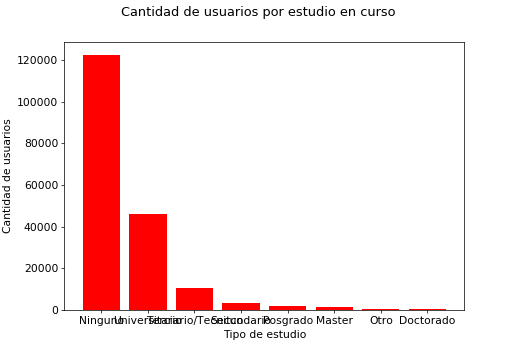

In [25]:
%matplotlib notebook
cant = usuarios_educacion_edad['estudio_en_curso'].value_counts()
estados = [1,2,3,4,5,6,7,8]
nombrestudio = ['Ninguno', 'Universitario', 'Terciario/Tecnitco', 'Secundario', 'Posgrado', 'Master', 'Otro', 'Doctorado']
plt.bar(estados, cant, color = 'red', capsize = 1)
plt.suptitle("Cantidad de usuarios por estudio en curso")
plt.xlabel("Tipo de estudio")
plt.ylabel("Cantidad de usuarios")
plt.xticks(estados, nombrestudio)
plt.show()

<IPython.core.display.Javascript object>


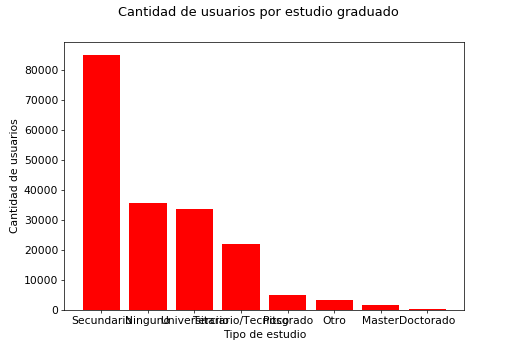

In [26]:
%matplotlib notebook
cant = usuarios_educacion_edad['estudio_graduado'].value_counts()
estados = [1,2,3,4,5,6,7,8]
nombrestudio = ['Secundario', 'Ninguno', 'Universitario', 'Terciario/Tecnitco', 'Posgrado', 'Otro', 'Master', 'Doctorado']
plt.bar(estados, cant, color = 'red')
plt.suptitle("Cantidad de usuarios por estudio graduado")
plt.xlabel("Tipo de estudio")
plt.ylabel("Cantidad de usuarios")
plt.xticks(estados, nombrestudio)
plt.show()

El hecho de que en ambos gráficos hubiera una gran cantidad de gente en la que no se especificaba el estudio nos hizo pensar que era una buena idea investigar que estudio terminado tenía la gente que no tenía nada en curso y viceversa

<IPython.core.display.Javascript object>


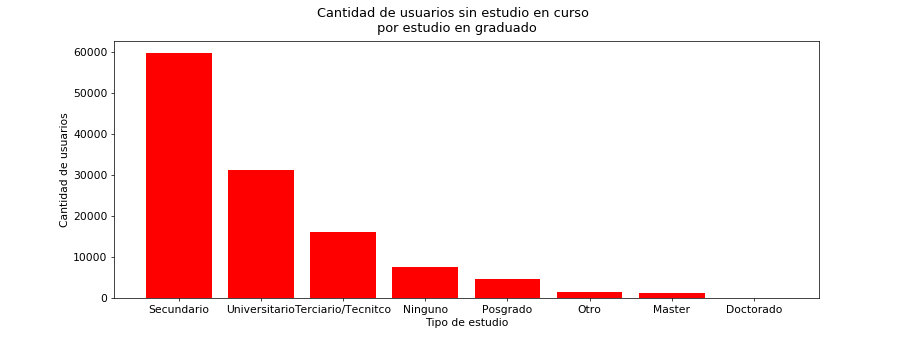

In [27]:
%matplotlib notebook
en_curso_vacio = usuarios_educacion_edad[usuarios_educacion_edad['estudio_en_curso'] == "Ninguno"]
cant = en_curso_vacio['estudio_graduado'].value_counts()
estados = [1,2,3,4,5,6,7,8]
nombrestudio = ['Secundario', 'Universitario', 'Terciario/Tecnitco', 'Ninguno', 'Posgrado', 'Otro', 'Master', 'Doctorado']
plt.bar(estados, cant, color = 'red')
plt.suptitle("Cantidad de usuarios sin estudio en curso \n por estudio en graduado")
plt.xlabel("Tipo de estudio")
plt.ylabel("Cantidad de usuarios")
plt.xticks(estados, nombrestudio)
plt.show()

<IPython.core.display.Javascript object>


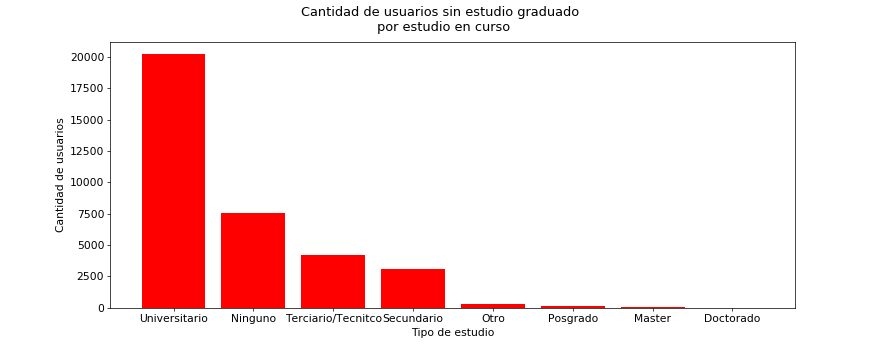

In [28]:
%matplotlib notebook
graduado_vacio = usuarios_educacion_edad[usuarios_educacion_edad['estudio_graduado'] == "Ninguno"]
cant = graduado_vacio['estudio_en_curso'].value_counts()
estados = [1,2,3,4,5,6,7,8]
nombrestudio = ['Universitario', 'Ninguno', 'Terciario/Tecnitco', 'Secundario', 'Otro', 'Posgrado', 'Master', 'Doctorado']
plt.bar(estados, cant, color = 'red')
plt.suptitle("Cantidad de usuarios sin estudio graduado \n por estudio en curso")
plt.xlabel("Tipo de estudio")
plt.ylabel("Cantidad de usuarios")
plt.xticks(estados, nombrestudio)
plt.show()

In [29]:
avisos_detalles['nivel_laboral'].value_counts()

Senior / Semi-Senior                    9404
Junior                                  2216
Otro                                     919
Jefe / Supervisor / Responsable          809
Gerencia / Alta Gerencia / Dirección     181
Name: nivel_laboral, dtype: int64

In [30]:
#funcionas auxiliares para graficar

def completoAEnum(completo):
    estudio = ['Ninguno', 'Otro', 'Secundario', 'Terciario/Técnico', 'Universitario', 'Master', 'Posgrado', 'Doctorado']
    for x in range(0,len(estudio)):
        if completo == estudio[x]:
            return x
    return 0
        
def aEnumNivel(nivel):
    if(nivel == 'Gerencia / Alta Gerencia / Dirección'):
        return 0
    if(nivel == 'Jefe / Supervisor / Responsable'):
        return 1
    if(nivel == 'Junior'):
        return 2
    if(nivel == 'Senior / Semi-Senior'):
        return 3
    return 4

def aEnumTipo(nivel):
    if(nivel == 'Full-time'):
        return 0
    if(nivel == 'Part-time'):
        return 1
    if(nivel == 'Teletrabajo'):
        return 2
    if(nivel == 'Pasantia'):
        return 3
    if(nivel == 'Por Horas'):
        return 4
    if(nivel == 'Temporario'):
        return 5
    if(nivel == 'Por Contrato'):
        return 6
    if(nivel == 'Fines de Semana'):
        return 7
    return 8

In [31]:
educacion_heat = usuarios_educacion_edad['estudio_graduado'].apply(lambda x: completoAEnum(x)).to_frame()
educacion_heat['en_curso'] = usuarios_educacion_edad['estudio_en_curso'].apply(lambda x: completoAEnum(x))
edu_matrix = educacion_heat.as_matrix()
edu_acu = np.zeros([8,8], dtype=int)
for elem in edu_matrix:
    edu_acu[elem[0]][elem[1]] += 1


<IPython.core.display.Javascript object>


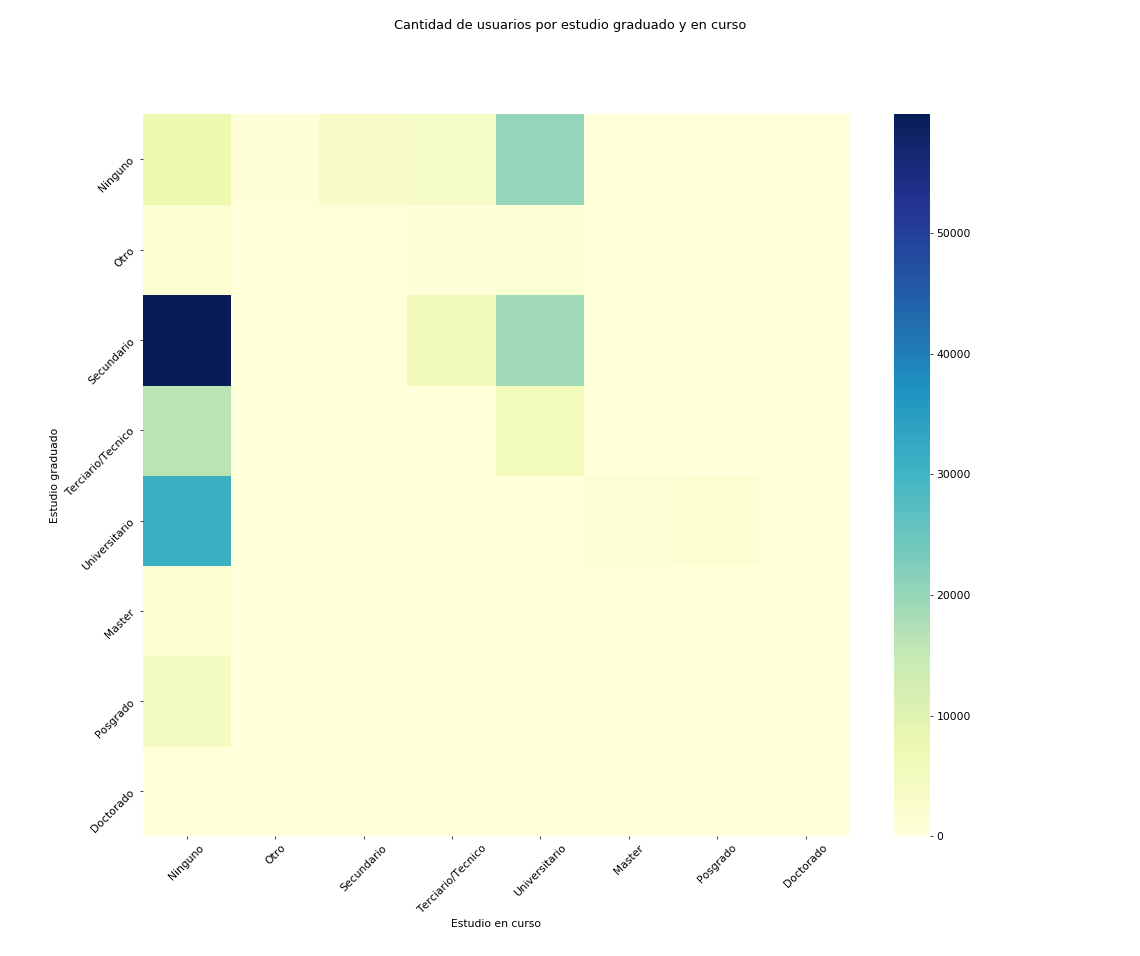

In [32]:
%matplotlib notebook
nombre_filas = ['Ninguno', 'Otro', 'Secundario', 'Terciario/Tecnico', 'Universitario', 'Master', 'Posgrado', 'Doctorado']
    
df_edu_acu = pd.DataFrame(edu_acu, index=nombre_filas)
nombres_columnas = {0: 'Ninguno',
                   1: 'Otro',
                   2: 'Secundario',
                   3: 'Terciario/Tecnico',
                   4: 'Universitario',
                   5: 'Master',
                   6: 'Posgrado',
                   7: 'Doctorado'}

df_edu_acu.rename(index=str, columns=nombres_columnas, inplace=True)

g = sns.heatmap(df_edu_acu, cmap="YlGnBu")
plt.xticks(rotation=45)
for item in g.get_yticklabels():
    item.set_rotation(45)
plt.suptitle("Cantidad de usuarios por estudio graduado y en curso")
plt.xlabel("Estudio en curso")
plt.ylabel("Estudio graduado")


### Plots de vista general

Los siguientes dos gráficos los hicimos porque queríamos ver la distribución de datos básicos como sexo de los usuarios y zona del aviso, pero no consideramos que pudieramos conseguir mucha información de ellos

In [35]:
#Zona Oeste solo tiene dos registros y pertenece al GBA, por otra parte el resto de las zonas no está representado
#y por eso decidimos combinar las dos posibles categorías en una
sin_Oeste = avisos_detalles[avisos_detalles['nombre_zona'] != 'GBA Oeste']
oeste = avisos_detalles[avisos_detalles['nombre_zona'] == 'GBA Oeste']
oeste['nombre_zona'] = 'Gran Buenos Aires'
avisos_detalles = sin_Oeste.append(oeste)
avisos_detalles['nombre_zona'].value_counts()

Gran Buenos Aires              12651
Capital Federal                  876
Buenos Aires (fuera de GBA)        2
Name: nombre_zona, dtype: int64

<IPython.core.display.Javascript object>


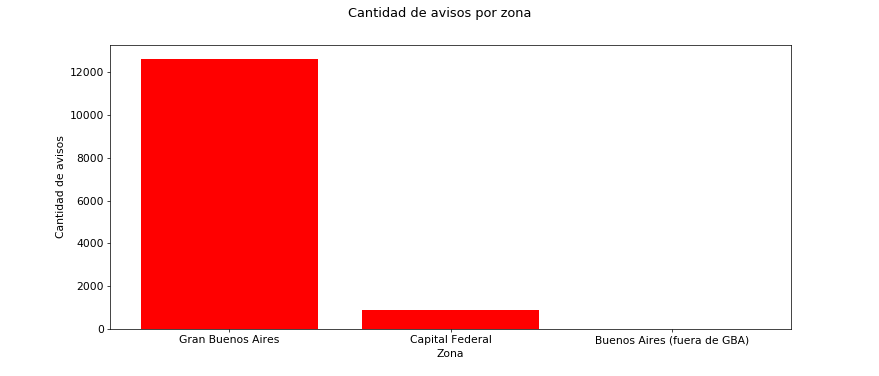

In [36]:
%matplotlib notebook
labels = ['Gran Buenos Aires', 'Capital Federal', 'Buenos Aires (fuera de GBA)']
cant_zona = avisos_detalles['nombre_zona'].value_counts().as_matrix()

zonas = [1,2,3]
plt.bar(zonas, cant_zona, color = 'red')

plt.suptitle("Cantidad de avisos por zona")
plt.xlabel("Zona")
plt.ylabel("Cantidad de avisos")

plt.xticks(zonas, labels)

plt.show()

<IPython.core.display.Javascript object>


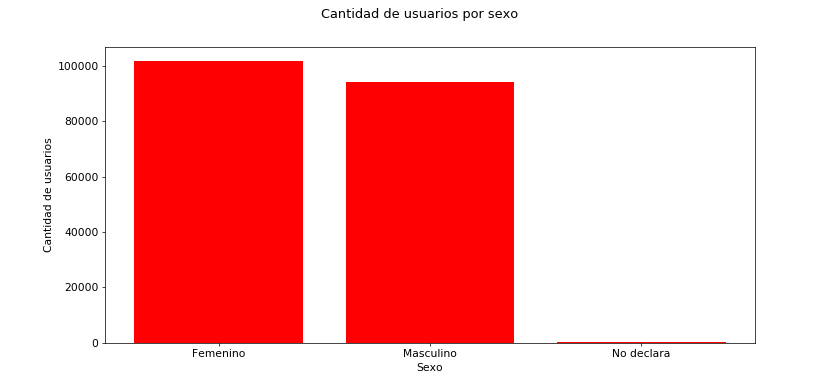

In [37]:
%matplotlib notebook

labels = ['Femenino', 'Masculino', 'No declara']
cant_sexo = genero_edad_filtrado['sexo'].value_counts().as_matrix()

zonas = [1,2,3]
plt.bar(zonas, cant_sexo, color = 'red')

plt.suptitle("Cantidad de usuarios por sexo")
plt.xlabel("Sexo")
plt.ylabel("Cantidad de usuarios")

plt.xticks(zonas, labels)
plt.show()

### Plots de postulaciones por usuario

In [38]:
postulaciones_por_usuario_filtrado = pd.DataFrame({
    'postulaciones_totales': postulaciones_filtrado.groupby('idpostulante')['idaviso'].count(),
}).reset_index()
print postulaciones_por_usuario_filtrado.postulaciones_totales.head(5), '\n'
print postulaciones_por_usuario_filtrado.postulaciones_totales.tail(5), '\n'
print postulaciones_por_usuario_filtrado.describe(include='all'), '\n'

0    34
1     3
2    17
3     1
4     1
Name: postulaciones_totales, dtype: int64 

185873     3
185874     5
185875    10
185876    11
185877    28
Name: postulaciones_totales, dtype: int64 

       idpostulante  postulaciones_totales
count        185878          185878.000000
unique       185878                    NaN
top         Rz6VOrE                    NaN
freq              1                    NaN
mean            NaN              17.580445
std             NaN              32.148423
min             NaN               1.000000
25%             NaN               4.000000
50%             NaN               9.000000
75%             NaN              19.000000
max             NaN            3166.000000 



<IPython.core.display.Javascript object>


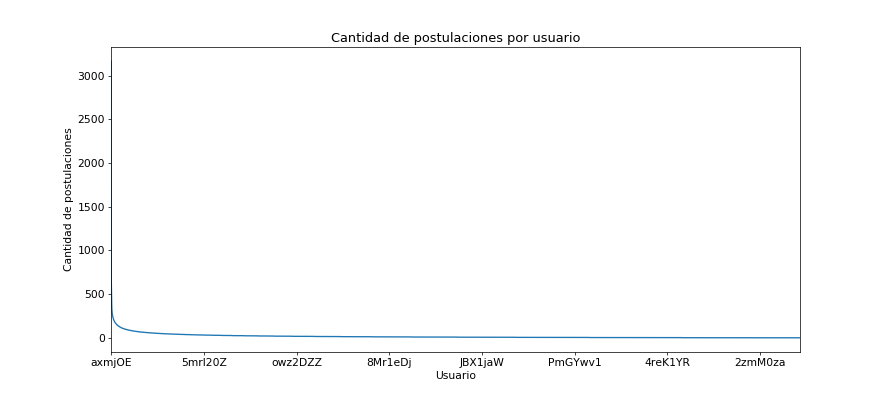

In [41]:
%matplotlib notebook
postulaciones_por_usuario_filtrado = postulaciones_por_usuario_filtrado.sort_values('postulaciones_totales', ascending=False)
grafico = postulaciones_por_usuario_filtrado.plot(x='idpostulante', y='postulaciones_totales', kind='line', title='Cantidad de postulaciones por usuario', legend=False)
grafico.set_xlabel("Usuario")
grafico.set_ylabel("Cantidad de postulaciones")

<IPython.core.display.Javascript object>


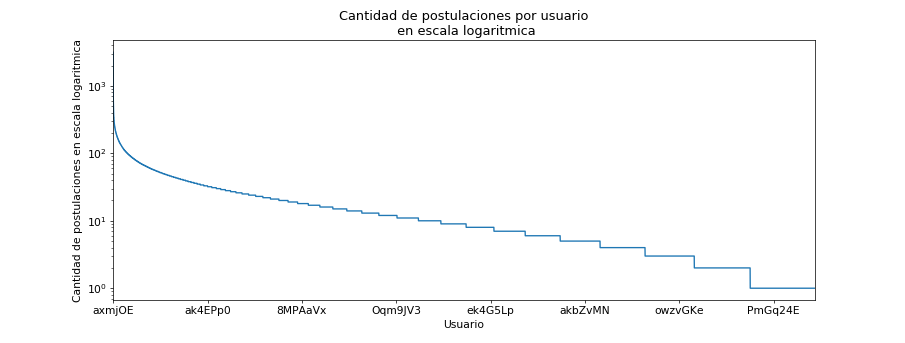

In [42]:
%matplotlib notebook
# Grafico en de postulaciones por usuario en escala logaritmica
graficoLog = postulaciones_por_usuario_filtrado.sort_values('postulaciones_totales', ascending=False).plot(x='idpostulante', y='postulaciones_totales', kind='line', logy=True, title='Cantidad de postulaciones por usuario\n en escala logaritmica', legend=False)
graficoLog.set_xlabel("Usuario")
graficoLog.set_ylabel("Cantidad de postulaciones en escala logaritmica")

In [43]:
total = postulaciones_por_usuario_filtrado.postulaciones_totales.sum()
print "Total postulaciones: %d" % total
top_20 = (len(postulaciones_por_usuario_filtrado))/5
total_top_20 = postulaciones_por_usuario_filtrado.head(top_20).postulaciones_totales.sum()
print "El 20%% de los usuarios con más postulaciones tiene un total de %d postulaciones" % total_top_20
perc_20 = total_top_20 / float(total) * 100
print "El 20%% de los usuarios con más postulaciones tiene el %f%% de las postulaciones" % perc_20

Total postulaciones: 3267818
El 20% de los usuarios con más postulaciones tiene un total de 2096161 postulaciones
El 20% de los usuarios con más postulaciones tiene el 64.145586% de las postulaciones


A partir de estos gráficos podemos ver que la distribución de las postulaciones por usuario es similar a una distribución de Pareto, a pesar de no ser una recta en el caso de la escala logarítmica. Analizando los datos de las postulaciones y visitas, vemos que las mismas comienzan el 15 de enero y las últimas corresponden al 28 de febrero. Es por esto que no deberían existir usuarios con más de 1000 postulaciones dado que esto es irreal.

### Plot de postulados por nivel y estudio

In [44]:
#Se consigue un dataframe con el mayor estudio graduado y el nivel que 
#pide la publicación a la que se postuló como valires numéricos
mejor_nivel_estudio = pd.merge(postulaciones_filtrado, avisos_detalles, how='inner', on='idaviso')
preplot = mejor_nivel_estudio['estudio_graduado'].to_frame()
preplot['nivel'] = mejor_nivel_estudio['nivel_laboral']
preplot['nivel'] = preplot['nivel'].apply(lambda x: aEnumNivel(x))
preplot['estudio_graduado'] = preplot['estudio_graduado'].apply(lambda x: completoAEnum(x))

In [45]:
mejor_nivel_estudio['nivel_laboral'].value_counts()

Senior / Semi-Senior                    1938939
Junior                                   667311
Otro                                     244864
Jefe / Supervisor / Responsable           82183
Gerencia / Alta Gerencia / Dirección      23154
Name: nivel_laboral, dtype: int64

In [51]:
%matplotlib notebook
import math

preplot_matriz = preplot.as_matrix()
acumulador = np.zeros([5, 8], dtype = float)
acumulador2 = np.zeros([5, 8], dtype = float)
for dupla in preplot_matriz:
    acumulador[dupla[1]][dupla[0]] = acumulador[dupla[1]][dupla[0]] + 1
for x in range (0,5):
    for y in range (0,8):
        acumulador2[x][y] = np.log10(acumulador[x][y])

In [47]:
nombres_filas = ['Gerencia\n/Alta Gerencia\n/Direccion',
                 'Jefe /\nSupervisor/\nResponsable',
                 'Junior',
                 'Senior/\nSemi-Senior',
                 'Otro']

df_acu = pd.DataFrame(acumulador, index=nombres_filas)
nombres_columnas = {0: 'Ninguno',
                   1: 'Otro',
                   2: 'Secundario',
                   3: 'Terciario/Tecnico',
                   4: 'Universitario',
                   5: 'Master',
                   6: 'Posgrado',
                   7: 'Doctorado'}

df_acu.rename(index=str, columns=nombres_columnas, inplace=True)
df_acu

,Ninguno,Otro,Secundario,Terciario/Tecnico,Universitario,Master,Posgrado,Doctorado
Gerencia\n/Alta Gerencia\n/Direccion,2794.0,251.0,4744.0,2372.0,8896.0,1127.0,2921.0,49.0
Jefe /\nSupervisor/\nResponsable,10433.0,1038.0,22003.0,9250.0,31462.0,1974.0,5890.0,133.0
Junior,124119.0,12114.0,328738.0,78212.0,109773.0,3307.0,10864.0,184.0
Senior/\nSemi-Senior,313804.0,34543.0,933914.0,233696.0,360181.0,15160.0,46743.0,898.0
Otro,40390.0,4814.0,141958.0,27089.0,26293.0,1060.0,3204.0,56.0


<IPython.core.display.Javascript object>


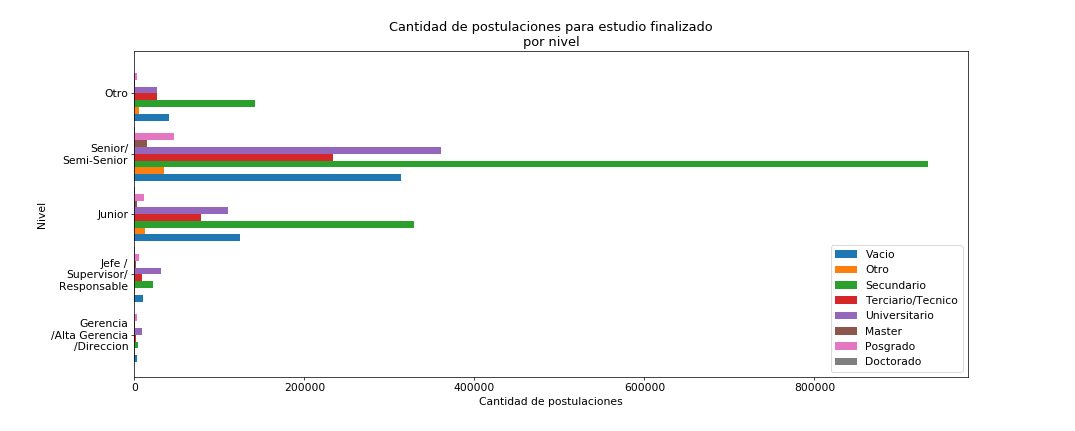

([<matplotlib.axis.YTick at 0x12b39908>,
 <a list of 5 Text yticklabel objects>)

In [48]:
%matplotlib notebook
auxiliar = pd.DataFrame(acumulador, columns=['Vacio', 'Otro', 'Secundario', 'Terciario/Tecnico', 'Universitario', 'Master', 'Posgrado', 'Doctorado'])
multibar = auxiliar.plot(kind='barh', title='Cantidad de postulaciones para estudio finalizado\n por nivel ', width=.9)
multibar.set_xlabel("Cantidad de postulaciones")
multibar.set_ylabel("Nivel")
plt.yticks([0,1,2,3,4], nombres_filas)

<IPython.core.display.Javascript object>


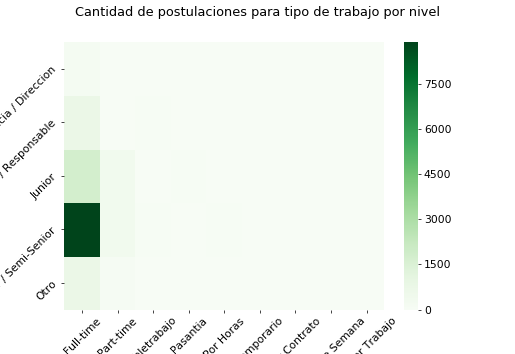

In [60]:
%matplotlib notebook

aux = avisos_detalles['nivel_laboral'].apply(lambda x: aEnumNivel(x)).to_frame()
aux['tipo_trabajo'] = avisos_detalles['tipo_de_trabajo'].apply(lambda x: aEnumTipo(x))
aux = aux.as_matrix()

acum = np.empty([5, 9], dtype = float)
for dupla in aux:
    acum[dupla[0]][dupla[1]] = acum[dupla[0]][dupla[1]] + 1

#Este for sirve para utilizar la escala logarítmica
for i in range (0, 5):
    for j in range (0, 9):
        acumLog[i,j] = math.log1p(acum[i,j])
        
nombres_filas = ['Gerencia / Alta Gerencia / Direccion',
                 'Jefe / Supervisor / Responsable',
                 'Junior',
                 'Senior / Semi-Senior',
                 'Otro']

df_acum = pd.DataFrame(acumLog, index=nombres_filas)
nombres_columnas = {0: 'Full-time',
                   1: 'Part-time',
                   2: 'Teletrabajo',
                   3: 'Pasantia',
                   4: 'Por Horas',
                   5: 'Temporario',
                   6: 'Por Contrato',
                   7: 'Fines de Semana',
                   8: 'Primer Trabajo'}

df_acum.rename(index=str, columns=nombres_columnas, inplace=True)

plt.xticks(rotation=45)
grafico = sns.heatmap(df_acum, cmap='Greens')
for item in grafico.get_yticklabels():
    item.set_rotation(45)
plt.suptitle("Cantidad de postulaciones para tipo de trabajo por nivel")
plt.xlabel("Tipo de trabajo")
plt.ylabel("Nivel buscado")
        
#plt.imshow(acum, cmap='magma', interpolation='nearest')
#plt.show()
#sns.heatmap(df_acum, cmap='Greens')

<IPython.core.display.Javascript object>


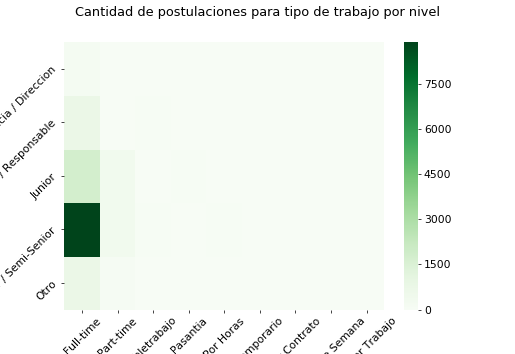

In [61]:
%matplotlib notebook
#Este es el gráfico sin la escala logarítmica, donde es dificil distinguir alto más allá de la columna de 
#Senior/Semi-senior
df_acum = pd.DataFrame(acum, index=nombres_filas)
nombres_columnas = {0: 'Full-time',
                   1: 'Part-time',
                   2: 'Teletrabajo',
                   3: 'Pasantia',
                   4: 'Por Horas',
                   5: 'Temporario',
                   6: 'Por Contrato',
                   7: 'Fines de Semana',
                   8: 'Primer Trabajo'}

df_acum.rename(index=str, columns=nombres_columnas, inplace=True)

plt.xticks(rotation=45)
grafico = sns.heatmap(df_acum, cmap='Greens')
for item in grafico.get_yticklabels():
    item.set_rotation(45)
plt.suptitle("Cantidad de postulaciones para tipo de trabajo por nivel")
plt.xlabel("Tipo de trabajo")
plt.ylabel("Nivel buscado")
        

### Plots de postulaciones por hora

In [62]:
posts = postulaciones['fechapostulacion'].apply(lambda x: x.split(" ")[1].split(":")[0]).as_matrix()

horas = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
for elem in posts:
    eleminto = int(elem)
    horas[eleminto] = horas[eleminto] + 1

In [66]:
horas_array = np.asarray(horas)

<IPython.core.display.Javascript object>


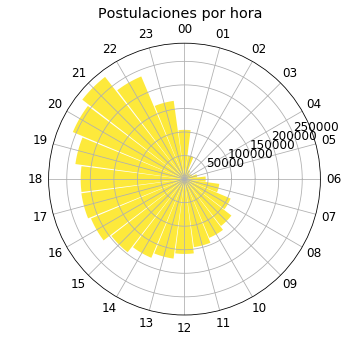

In [443]:
# %matplotlib notebook
# Las horas están corridas con respecto a las anotaciones
# N = 24 #cantidad de horas
# theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
# radii = horas_array
# width = np.pi / 6.3 *  np.asarray([.5, .5, .5, .5, .5, .5, .5, .5, .5, .5, .5, .5, .5, .5, .5, .5, .5, .5, .5, .5, .5, .5, .5, .5])
# ax = plt.subplot(111, projection='polar')
# bars = ax.bar(theta, radii, width=width, bottom=0.0)

# # Use custom colors and opacity
# for r, bar in zip(radii, bars):
#     bar.set_facecolor(plt.cm.viridis(r / 10.))
#     bar.set_alpha(.9)

# angulos = np.zeros([24,1], dtype = float)
# horas = ["00", "23", "22", "21", "20", "19", "18", "17", "16", "15", "14", "13", "12", "11", "10", "09", "08", "07", "06", "05", "04", "03", "02", "01"]
# for hora in horas:
#     angulos[int(hora)] = (int(hora))*(2*np.pi)/24 + np.pi/2
# plt.suptitle("Postulaciones por hora")
# plt.xticks(angulos, horas)

# plt.show()

<IPython.core.display.Javascript object>


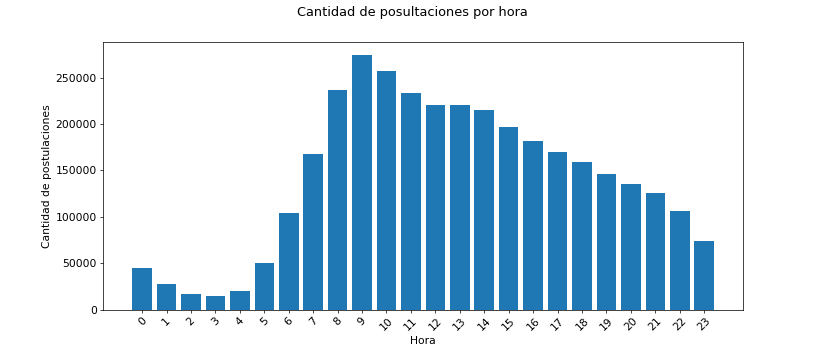

In [67]:
%matplotlib notebook
hours = horas[::-1]
hours = np.roll(estados,0)
estados = range(0,24)
nivel = plt.bar(estados, horas_array)
plt.suptitle("Cantidad de posultaciones por hora")
plt.xlabel("Hora")
plt.ylabel("Cantidad de postulaciones")
plt.xticks(estados, hours, rotation=45)
plt.show()

### Edades de los potulantes

Encontramos muchos casos de gente con una edad demasiado elevada como para ser reales. Muchas tienen aspecto de años cercanos. Hubo un caso en el que había una persona que tenía 12 años, que decidimos sacar. Decidimos arbitrariamente filtrar a los mayores de 100.

In [68]:
import dateutil 
edades = usuarios_educacion_edad.copy()
edades['edades'] = edades['fechanacimiento'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d").date())
edades['edades'] = edades['edades'].apply(lambda x: int(dateutil.relativedelta.relativedelta(datetime.datetime.utcnow().date(),x).years))

In [69]:
edades_extranias = edades[edades['edades'] > 100]
print(edades_extranias.shape)
edades_extranias

(7, 6)


,idpostulante,fechanacimiento,sexo,estudio_en_curso,estudio_graduado,edades
54337,xkPwXwY,0031-12-11,FEM,Ninguno,Secundario,1986
69329,LN85Y3b,0029-05-11,MASC,Ninguno,Secundario,1988
137293,A36Npjj,0033-09-14,FEM,Universitario,Ninguno,1984
140752,dYjV0rb,0012-11-04,NO_DECLARA,Universitario,Ninguno,2005
143343,GNZOvAv,0004-07-19,MASC,Universitario,Ninguno,2013
144225,1QPQ8QL,0011-03-08,MASC,Secundario,Ninguno,2007
148438,xkdvwm0,1775-07-09,MASC,Otro,Ninguno,242


In [70]:
#Se filtran los outliers
edades = edades[edades['edades'] < 100]
edades = edades[edades['edades'] > 17]
array_edades = edades['edades'].as_matrix()

In [71]:
acum_edades = np.zeros([10, 1], dtype = float)
acum_edades_full = np.zeros([83,1], dtype = int)
for elem in array_edades:
    acum_edades_full[elem-17] += 1
xaxis = []
xaxisFull = []
xaxisHist = []
for x in range (0, 100, 10):
    xaxis.append(str(x))

for y in range (0,83):
    xaxisFull.append(y+17)

<IPython.core.display.Javascript object>


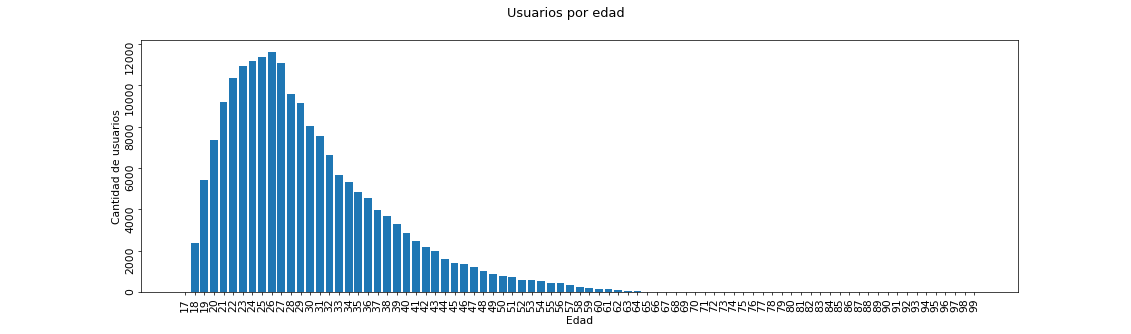

(array([     0.,   2000.,   4000.,   6000.,   8000.,  10000.,  12000.,
         14000.]), <a list of 8 Text yticklabel objects>)

In [72]:
%matplotlib notebook
plt.bar(xaxisFull, acum_edades_full)
plt.suptitle("Usuarios por edad")
plt.xlabel("Edad")
plt.ylabel("Cantidad de usuarios")
plt.xticks(xaxisFull, xaxisFull, rotation=90)
plt.yticks(rotation = 90)

### Cantidades de postulaciones por aviso

In [73]:
postutalles = pd.merge(postulaciones_filtrado, avisos_detalles, on = 'idaviso', how = 'inner')

In [75]:
postutalles2 = pd.DataFrame({
    'postulaciones_totales': postutalles.groupby('nombre_area')['idaviso'].count(),
}).reset_index()
postutalles2 = postutalles2.sort_values('postulaciones_totales')

### Plot cantidad de avisos por nivel buscado

<IPython.core.display.Javascript object>


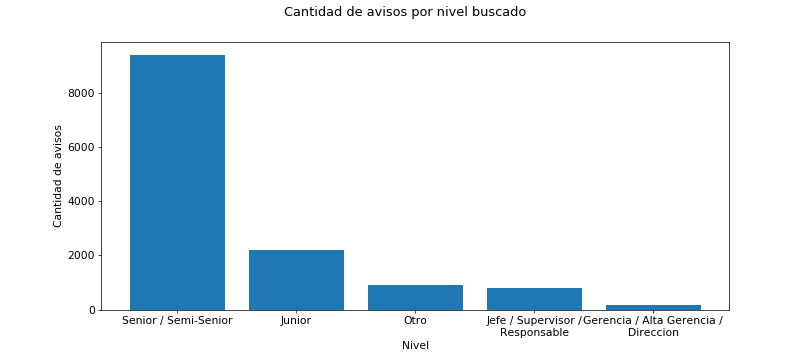

In [76]:
#grafico de barras de tipo de estudio por estado
%matplotlib notebook
cant_av = avisos_detalles['nivel_laboral'].value_counts().as_matrix()
estados = [1,2,3,4,5]
nivel = ['Senior / Semi-Senior', 'Junior', 'Otro', 'Jefe / Supervisor /\nResponsable', 'Gerencia / Alta Gerencia /\nDireccion']
plt.bar(estados, cant_av)
plt.suptitle("Cantidad de avisos por nivel buscado")
plt.xlabel("Nivel")
plt.ylabel("Cantidad de avisos")
plt.xticks(estados, nivel)
plt.show()

<IPython.core.display.Javascript object>


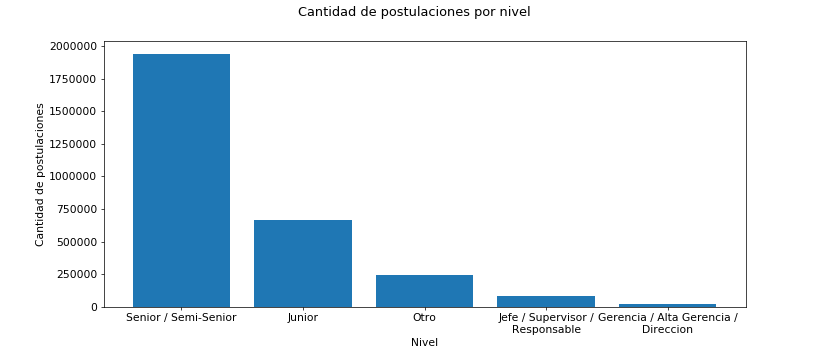

In [77]:
#postulaciones por nivel
%matplotlib notebook
cant_pos = postutalles['nivel_laboral'].value_counts().as_matrix()
estados = [1,2,3,4,5]
momos = ['Senior / Semi-Senior', 'Junior', 'Otro', 'Jefe / Supervisor /\nResponsable', 'Gerencia / Alta Gerencia /\nDireccion']
plt.bar(estados, cant_pos)
plt.suptitle("Cantidad de postulaciones por nivel")
plt.xlabel("Nivel")
plt.ylabel("Cantidad de postulaciones")
plt.xticks(estados, momos)
plt.show()

### Plot postulaciones por area 

<IPython.core.display.Javascript object>


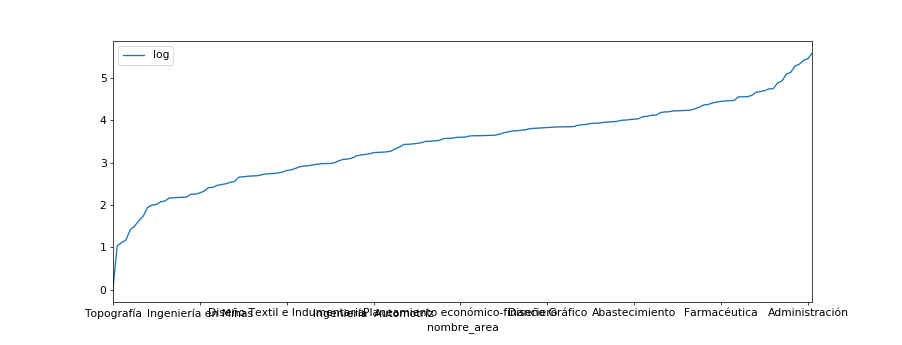

In [82]:
postutalles2['log'] = postutalles2['postulaciones_totales'].apply(lambda x: math.log10(x))
postutalles2.plot(x='nombre_area', y='log', kind='line')

<IPython.core.display.Javascript object>


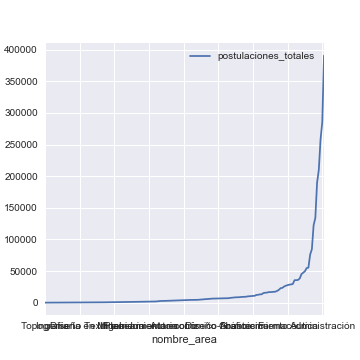

In [164]:
postutalles2.plot(x='nombre_area', y='postulaciones_totales', kind='line')

### Plot de postuación por estudios

<IPython.core.display.Javascript object>


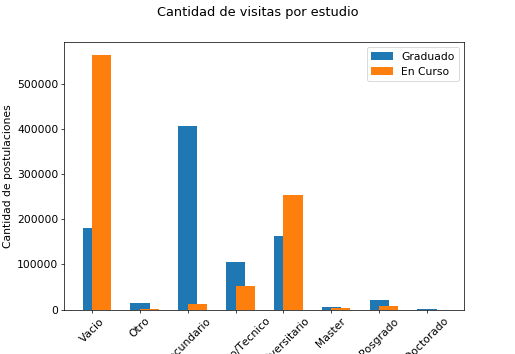

In [86]:
#gente por estudio
%matplotlib notebook
arrGrad = visitas_filtrado['estudio_graduado'].apply(lambda x: completoAEnum(x)).values
arrCurs = visitas_filtrado['estudio_en_curso'].apply(lambda x: completoAEnum(x)).values
cantCurso = [0,0,0,0,0,0,0,0]
cantGrad = [0,0,0,0,0,0,0,0]
for x in range (0,len(arrGrad)):
    cantGrad[int(arrGrad[x])] = cantGrad[int(arrGrad[x])] + 1
    cantCurso[int(arrCurs[x])] = cantCurso[int(arrCurs[x])] + 1

number = [0,1,2,3,4,5,6,7]
estudios = ['Vacio', 'Otro', 'Secundario', 'Terciario/Tecnico', 'Universitario', 'Master', 'Posgrado', 'Doctorado']
bar1 = plt.bar(number, cantGrad, width = 0.4)
bar2 = plt.bar(number, cantCurso, width = 0.4, align = 'edge')
plt.suptitle("Cantidad de visitas por estudio")
plt.legend((bar1, bar2), ('Graduado', 'En Curso'))
plt.xlabel("Tipo de estudio")
plt.ylabel("Cantidad de postulaciones")
plt.xticks(number, estudios, rotation=45)
plt.show()

<IPython.core.display.Javascript object>


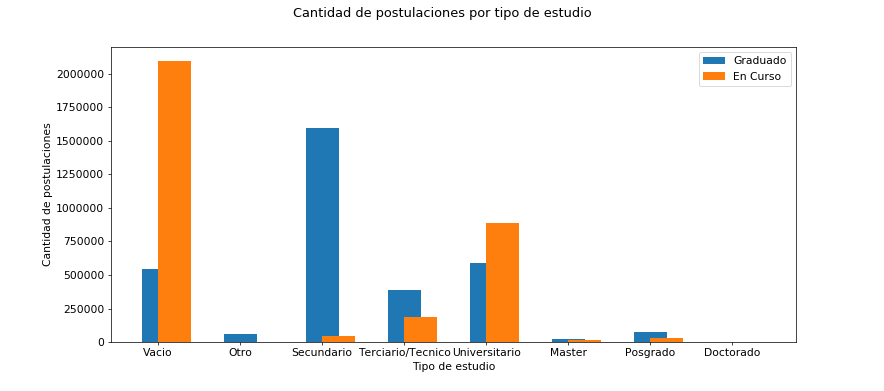

In [87]:
#postulaciones por estudio
%matplotlib notebook
#postulaciones_filtrado
arrGrad = postulaciones_filtrado['estudio_graduado'].apply(lambda x: completoAEnum(x)).values
arrCurs = postulaciones_filtrado['estudio_en_curso'].apply(lambda x: completoAEnum(x)).values
cantCurso = [0,0,0,0,0,0,0,0]
cantGrad = [0,0,0,0,0,0,0,0]
for x in range (0,len(arrGrad)):
    cantGrad[arrGrad[x]] = cantGrad[arrGrad[x]] + 1
    cantCurso[arrCurs[x]] = cantCurso[arrCurs[x]] + 1
    
number = [0,1,2,3,4,5,6,7]
estudios = ['Vacio', 'Otro', 'Secundario', 'Terciario/Tecnico', 'Universitario', 'Master', 'Posgrado', 'Doctorado']
bar1 = plt.bar(number, cantGrad, width = 0.4)
bar2 = plt.bar(number, cantCurso, width = 0.4, align = 'edge')
plt.legend((bar1, bar2), ('Graduado', 'En Curso'))
plt.suptitle("Cantidad de postulaciones por tipo de estudio")
plt.xlabel("Tipo de estudio")
plt.ylabel("Cantidad de postulaciones")
plt.xticks(number, estudios)
plt.show()

### Plots con respecto a los días de la semana

In [88]:
def day2number(day):
    if(day == "Monday"):
        return 0
    if(day == "Tuesday"):
        return 1
    if(day == "Wednesday"):
        return 2
    if(day == "Thursday"):
        return 3
    if(day == "Friday"):
        return 4
    if(day == "Saturday"):
        return 5
    return 6
    

In [81]:
count_dias_post = [0, 0, 0, 0, 0, 0, 0]
vecPostulacion = postulaciones_filtrado['fechapostulacion'].apply(lambda x: datetime.date(int(x.split(" ")[0].split("-")[0]),int(x.split(" ")[0].split("-")[1]),int(x.split(" ")[0].split("-")[2])).strftime("%A"))
for elem in vecPostulacion:
    count_dias_post[day2number(elem)] = count_dias_post[day2number(elem)] + 1

<IPython.core.display.Javascript object>


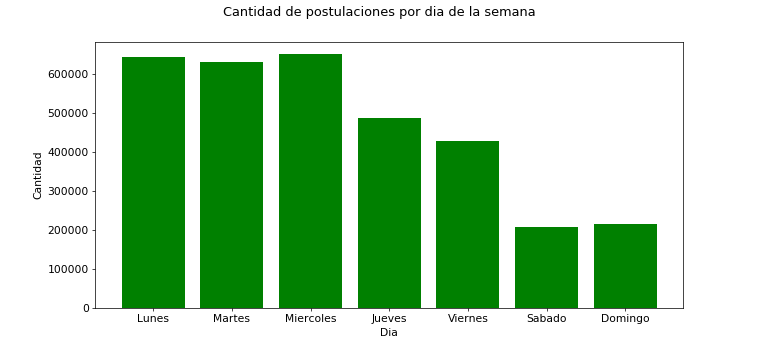

In [89]:
#Cantidad de postulaciones por día de la semana
%matplotlib notebook
estados = [1,2,3,4,5,6,7]
dias = ['Lunes', 'Martes', 'Miercoles', 'Jueves', 'Viernes', 'Sabado', 'Domingo']
plt.bar(estados, count_dias_post, color = 'green')
plt.suptitle("Cantidad de postulaciones por dia de la semana")
plt.xlabel("Dia")
plt.ylabel("Cantidad")
plt.xticks(estados, dias)
plt.show()

In [90]:
count_dias_visitas = [0, 0, 0, 0, 0, 0, 0]
vecVisitas = visitas_filtrado['timestamp'].apply(lambda x: datetime.date(int(x.split("T")[0].split("-")[0]),int(x.split("T")[0].split("-")[1]),int(x.split("T")[0].split("-")[2])).strftime("%A"))
for elem in vecVisitas:
    count_dias_visitas[day2number(elem)] = count_dias_visitas[day2number(elem)] + 1

<IPython.core.display.Javascript object>


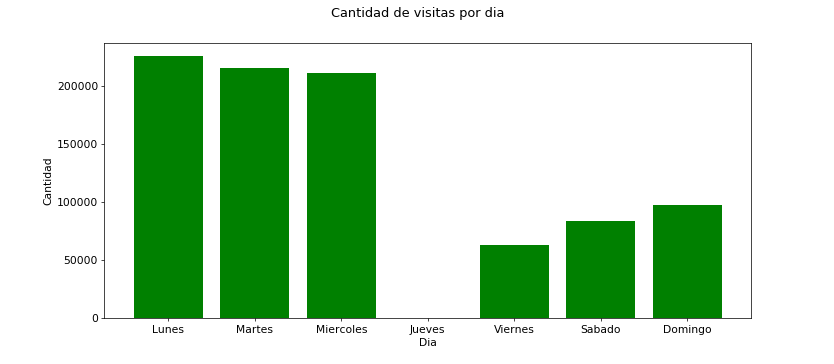

In [91]:
%matplotlib notebook
plt.bar(estados, count_dias_visitas, color = 'green')
plt.suptitle("Cantidad de visitas por dia")
plt.xlabel("Dia")
plt.ylabel("Cantidad")
plt.xticks(estados, dias)
plt.show()

In [92]:
#funcion harcodeada para buscar jueves en las visitas
def esJueves(preFecha):
    fecha = preFecha.split("T")[0].split("-")
    if fecha[1] == "01":
        return (fecha in (4, 11, 18, 25))
    return (fecha in (1, 8, 15, 22))

In [93]:
hayJueves = visitas['timestamp'].apply(lambda x: esJueves(x))

nrio = False
for dia in hayJueves:
    nrio = nrio or dia
nrio

False

### Plot de horas en las que se postula para cada día de la semana

<IPython.core.display.Javascript object>


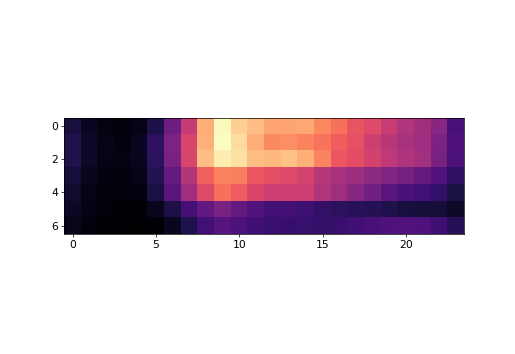

In [94]:
#heatmap obsoleto
# %matplotlib notebook

# count_hora = np.zeros([7,24], dtype = int)

# aux = postulaciones_filtrado
# aux['dia'] = aux['fechapostulacion'].apply(lambda x: datetime.date(int(x.split(" ")[0].split("-")[0]),int(x.split(" ")[0].split("-")[1]),int(x.split(" ")[0].split("-")[2])).strftime("%A"))
# aux['hora'] = aux['fechapostulacion'].apply(lambda x: x.split(" ")[1].split(":")[0])

# lun = aux[aux['dia'] == "Monday"]['hora'].as_matrix()
# mar = aux[aux['dia'] == "Tuesday"]['hora'].as_matrix()
# mie = aux[aux['dia'] == "Wednesday"]['hora'].as_matrix()
# jue = aux[aux['dia'] == "Thursday"]['hora'].as_matrix()
# vie = aux[aux['dia'] == "Friday"]['hora'].as_matrix()
# sab = aux[aux['dia'] == "Saturday"]['hora'].as_matrix()
# dom = aux[aux['dia'] == "Sunday"]['hora'].as_matrix()

# sumhora = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# iterar = (lun, mar, mie, jue, vie, sab, dom)

# for x in range (0,7):
#     for hora in iterar[x]:
#         count_hora[x][int(hora)] = count_hora[x][int(hora)] + 1

# plt.imshow(count_hora, cmap='magma', interpolation='nearest')
# plt.show()

In [95]:
count_hora2 = pd.DataFrame(count_hora, index=dias)
count_hora2

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Lunes,6926,4035,2766,2227,3212,7738,17656,28559,43569,51800,...,42906,39373,36898,33564,31876,28719,26076,24083,20893,13073
Martes,8007,4720,2997,2507,4063,9669,19437,30926,43943,52164,...,39158,37238,34794,32885,29555,27150,24993,23912,19436,13626
Miercoles,7969,4929,3041,2597,4081,9505,19013,30794,45174,50561,...,43571,39105,33844,32437,30372,27377,25876,24314,18948,13449
Jueves,6554,3915,2435,1871,3292,8510,16326,26218,35361,38877,...,30508,26840,24969,23526,21387,19995,18614,16689,14033,10055
Viernes,5428,3349,2038,1895,2399,7095,15267,23778,31631,36791,...,29006,26165,23775,20629,18154,15275,13231,12063,10311,7014
Sabado,4455,2961,1814,1374,1457,3876,7586,12454,16129,19273,...,11421,10215,9394,9101,8605,8007,6963,6461,6218,4799
Domingo,3494,2201,1462,1122,990,1751,4109,7831,12055,14590,...,10929,10549,11075,11817,12953,13740,14091,13592,11786,8915


<IPython.core.display.Javascript object>


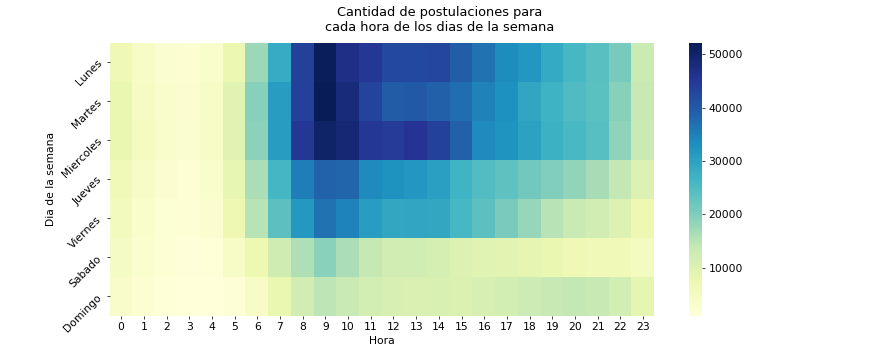

In [96]:
%matplotlib notebook
graf = sns.heatmap(count_hora2, cmap="YlGnBu")
for item in graf.get_yticklabels():
    item.set_rotation(45)
plt.suptitle("Cantidad de postulaciones para\ncada hora de los dias de la semana")
plt.xlabel("Hora")
plt.ylabel("Dia de la semana")
    

### Postulaciones promedio de avisos online vs offline

In [97]:
avisos_detalles_online = pd.merge(avisos_detalles, avisos_online, how='inner', on='idaviso')
avisos_offline = avisos_detalles[~avisos_detalles.idaviso.isin(avisos_detalles_online.idaviso)]
print "Cantidad de avisos online con detalle:", len(avisos_detalles_online)
print "Cantidad de avisos offline con detalle:", len(avisos_offline)
print "Cantidad total de avisos con detalle:", len(avisos_detalles)

Cantidad de avisos online con detalle: 4713
Cantidad de avisos offline con detalle: 8816
Cantidad total de avisos con detalle: 13529


In [98]:
postulaciones_avisos_online = pd.merge(avisos_detalles_online, postulaciones_filtrado, how='inner', on='idaviso')
postulaciones_avisos_offline = pd.merge(avisos_offline, postulaciones_filtrado, how='inner', on='idaviso')
print "Cantidad de postulaciones a aviso online con detalle:", len(postulaciones_avisos_online)
print "Cantidad de postulaciones a aviso offline con detalle:", len(postulaciones_avisos_offline)
print "Cantidad total de postulaciones:", len(postulaciones_filtrado)
len(pd.merge(avisos_detalles, postulaciones_filtrado, how='inner', on='idaviso'))

Cantidad de postulaciones a aviso online con detalle: 1197782
Cantidad de postulaciones a aviso offline con detalle: 1758669
Cantidad total de postulaciones: 3267818


2956451

In [99]:
postulaciones_avisos_online['postulaciones_total'] = 1
print postulaciones_avisos_online.groupby('idaviso').postulaciones_total.sum().mean()
postulaciones_avisos_offline['postulaciones_total'] = 1
print postulaciones_avisos_offline.groupby('idaviso').postulaciones_total.sum().mean()

350.126278866
223.039822448
